In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
columns = ['Date', 'AvgTemp', 'MinTemp', 'MaxTemp', 'AvgMinTemp', 'AvgMaxTemp', 
           'LowestTemp', 'HighestTemp', 'ActualRain', 'AvgRain', 'MaxRain']
df = pd.read_csv('Assessment-3-Datasets/DMVA3DT2-Weather.csv', names=columns)

print(df)

# Convert 'Date' to datetime and other columns to numeric
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Selecting relevant columns for anomaly detection
features = df[['AvgTemp', 'MinTemp', 'MaxTemp', 'ActualRain']].dropna()

# 1. Local Outlier Factor (LOC)
loc = LocalOutlierFactor(n_neighbors=15, contamination=0.05)
df['LOC_anomaly'] = loc.fit_predict(features)

# 2. Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['IF_anomaly'] = iso_forest.fit_predict(features)

# 3. One-Class SVM
svm = OneClassSVM(nu=0.05, gamma='auto')
df['SVM_anomaly'] = svm.fit_predict(features)

# Mark anomalies in a combined column (any detection is an anomaly)
df['Anomaly'] = df[['LOC_anomaly', 'IF_anomaly', 'SVM_anomaly']].apply(
    lambda row: -1 if any(row == -1) else 1, axis=1
)


           Date  AvgTemp  MinTemp  MaxTemp  AvgMinTemp  AvgMaxTemp  \
0     1/07/2022       76       66       86          66          85   
1     2/07/2022       71       63       79          66          85   
2     3/07/2022       67       60       73          66          85   
3     4/07/2022       67       54       79          66          85   
4     5/07/2022       69       59       79          66          85   
..          ...      ...      ...      ...         ...         ...   
360  26/06/2023       71       66       76          65          85   
361  27/06/2023       66       60       72          65          85   
362  28/06/2023       67       55       78          65          85   
363  29/06/2023       70       63       77          65          85   
364  30/06/2023       73       64       82          65          85   

     LowestTemp  HighestTemp  ActualRain  AvgRain  MaxRain  
0            48           97        0.13     0.16     5.09  
1            50           99        0

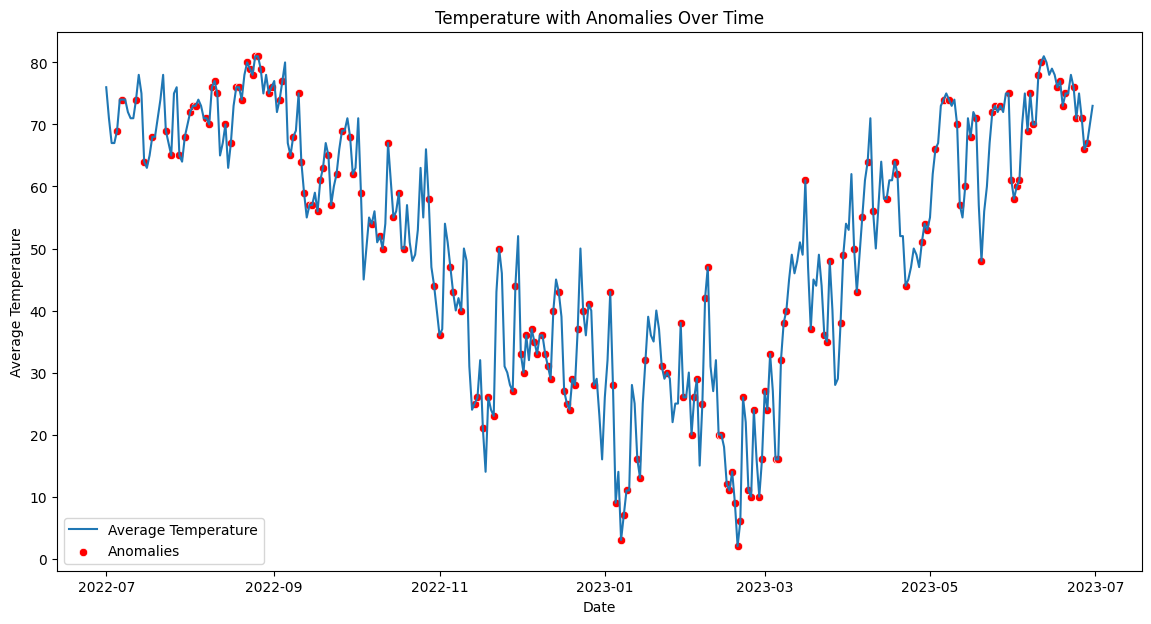

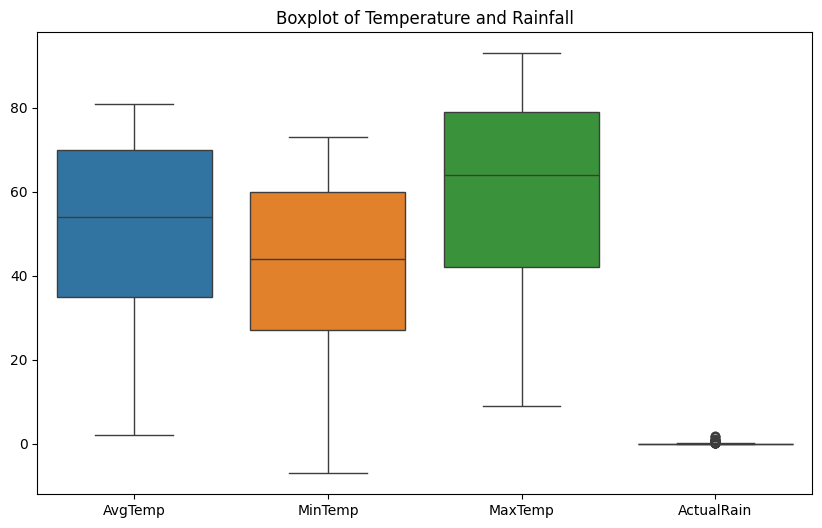

In [3]:
# Visualize anomalies in temperature and rainfall over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='Date', y='AvgTemp', label='Average Temperature')
sns.scatterplot(data=df[df['Anomaly'] == -1], x='Date', y='AvgTemp', color='red', label='Anomalies')
plt.title("Temperature with Anomalies Over Time")
plt.xlabel("Date")
plt.ylabel("Average Temperature")
plt.legend()
plt.show()

# Box plot to visualize distribution and anomalies in temperatures
plt.figure(figsize=(10, 6))
sns.boxplot(data=features[['AvgTemp', 'MinTemp', 'MaxTemp', 'ActualRain']])
plt.title("Boxplot of Temperature and Rainfall")
plt.show()


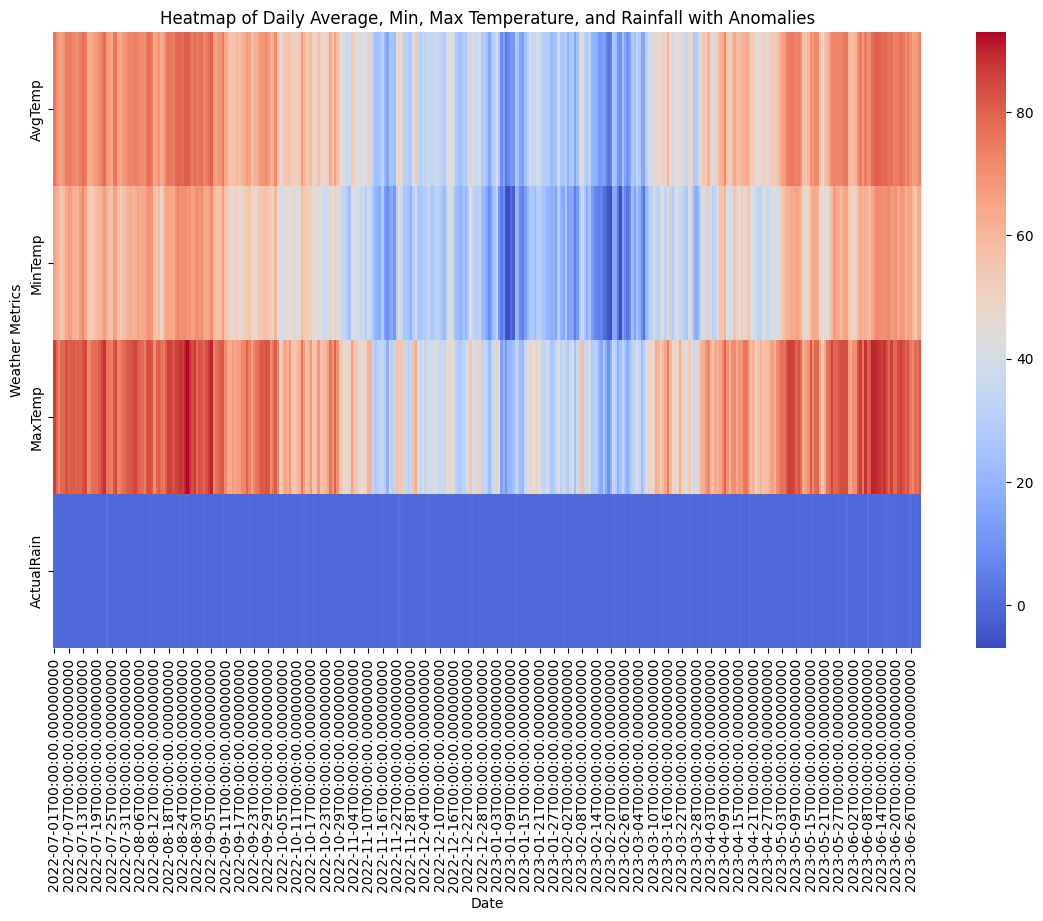

In [4]:
import seaborn as sns

# Create a matrix with 'Date' as index and 'AvgTemp', 'MinTemp', 'MaxTemp', 'ActualRain' columns
df.set_index('Date', inplace=True)
temp_rain_matrix = df[['AvgTemp', 'MinTemp', 'MaxTemp', 'ActualRain']].T

# Plot heatmap with annotations for anomalies
plt.figure(figsize=(14, 8))
sns.heatmap(temp_rain_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Heatmap of Daily Average, Min, Max Temperature, and Rainfall with Anomalies")
plt.xlabel("Date")
plt.ylabel("Weather Metrics")
plt.show()


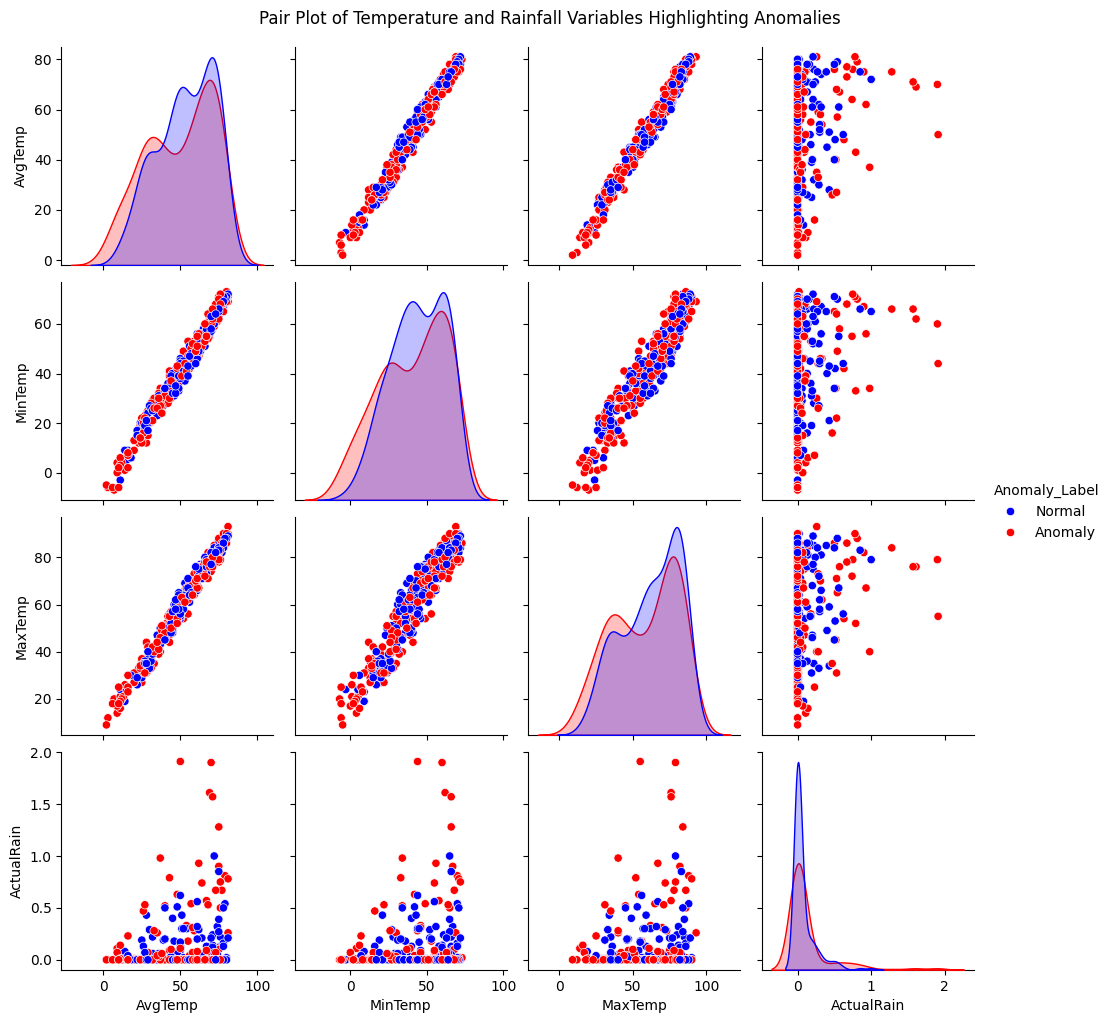

In [5]:
import seaborn as sns

# Add a column to indicate if a day was an anomaly
df['Anomaly_Label'] = df['Anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

# Use pairplot to show relationship among variables with anomaly labels
sns.pairplot(df[['AvgTemp', 'MinTemp', 'MaxTemp', 'ActualRain', 'Anomaly_Label']], 
             hue='Anomaly_Label', palette={'Anomaly': 'red', 'Normal': 'blue'}, diag_kind='kde')
plt.suptitle("Pair Plot of Temperature and Rainfall Variables Highlighting Anomalies", y=1.02)
plt.show()


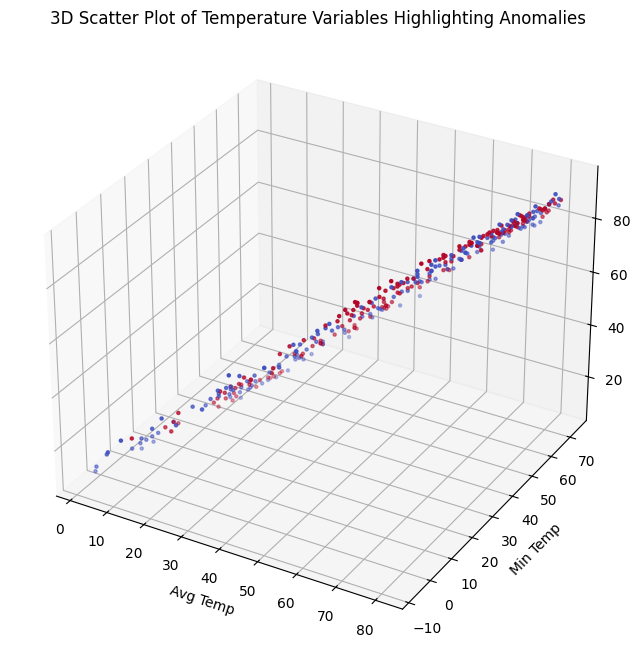

In [6]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points with anomaly labels
ax.scatter(df['AvgTemp'], df['MinTemp'], df['MaxTemp'], 
           c=df['Anomaly'], cmap='coolwarm', marker='o', s=5)
ax.set_xlabel("Avg Temp")
ax.set_ylabel("Min Temp")
ax.set_zlabel("Max Temp")
ax.set_title("3D Scatter Plot of Temperature Variables Highlighting Anomalies")

plt.show()


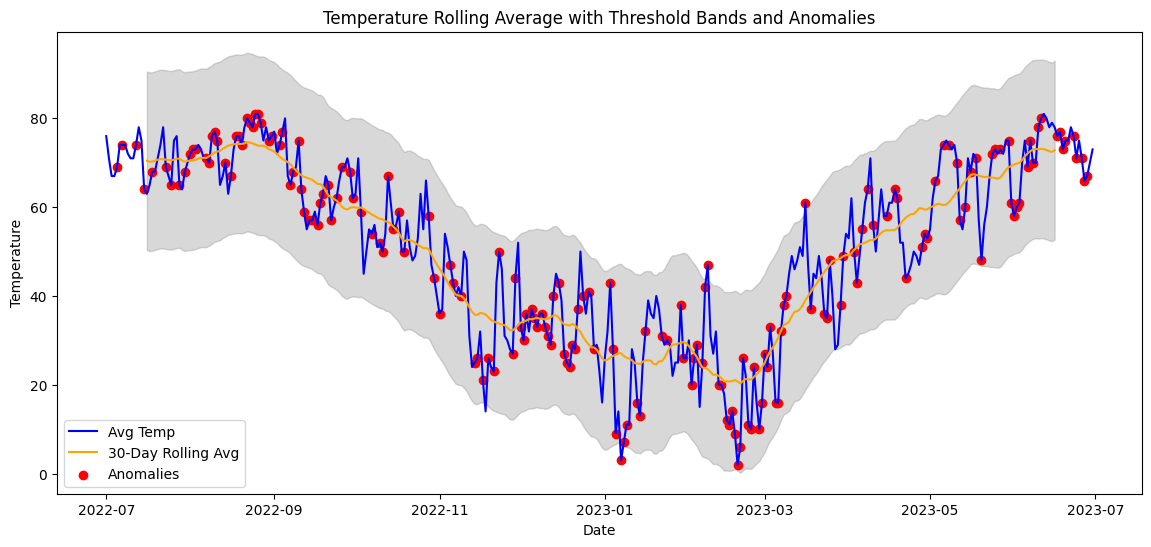

In [7]:
# Calculate rolling average and thresholds
df['RollingAvg'] = df['AvgTemp'].rolling(window=30, center=True).mean()
df['Upper_Threshold'] = df['RollingAvg'] + df['AvgTemp'].std()
df['Lower_Threshold'] = df['RollingAvg'] - df['AvgTemp'].std()

# Plot rolling average with threshold bands and anomalies
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['AvgTemp'], color='blue', label='Avg Temp')
plt.plot(df.index, df['RollingAvg'], color='orange', label='30-Day Rolling Avg')
plt.fill_between(df.index, df['Upper_Threshold'], df['Lower_Threshold'], color='gray', alpha=0.3)
plt.scatter(df[df['Anomaly'] == -1].index, df[df['Anomaly'] == -1]['AvgTemp'], color='red', label='Anomalies')
plt.title("Temperature Rolling Average with Threshold Bands and Anomalies")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()


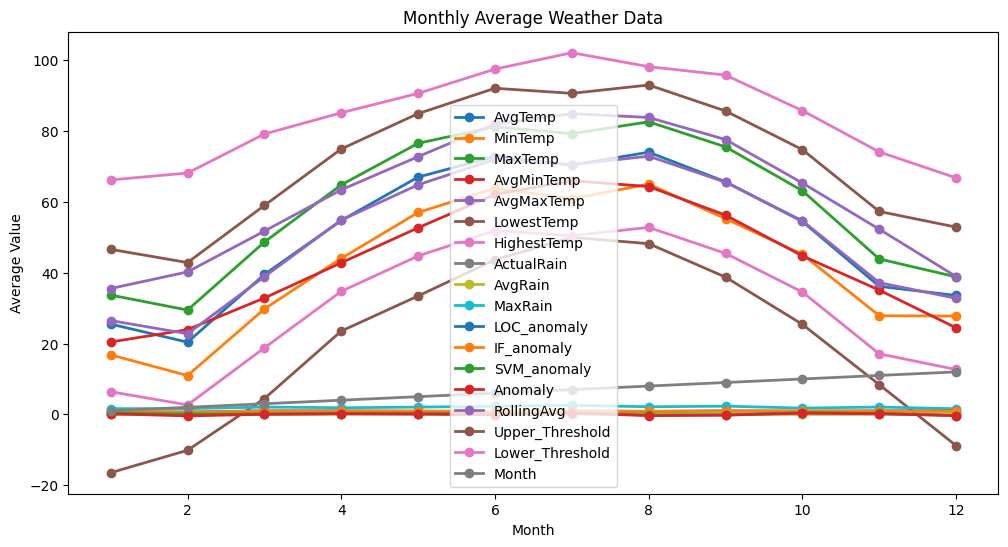